# Credit card fraud detection

#### This notebook will test different methods on skewed data. The idea is to compare if preprocessing techniques work better when there is an overwhelming majority class that can disrupt the efficiency of our predictive model.

#### You will also be able to see how to apply cross validation for hyperparameter tuning on different classification models. My intention is to create models using:
1. Logistic Regression
2. SVMs
3. Decision trees
4. I also want to have a try at anomaly detection techniques, but I still have to investigate a bit on that, so any advise will be appreciated!

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

# Loading the dataset

In [101]:
data = pd.read_csv("./creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Checking the target classes

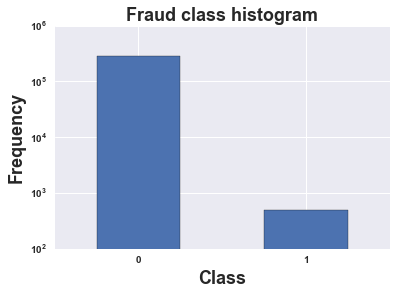

In [102]:
sns.set()
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
hfont = {'size':'18', 'weight': 'bold'}
plt.rc('font', **hfont)
plt.title("Fraud class histogram", **hfont)
plt.xticks(rotation=0)
plt.yscale("log")
plt.xlabel("Class", **hfont)
plt.ylabel("Frequency", **hfont)
plt.savefig('Fraud Class Histogram.png', dpi = 300)

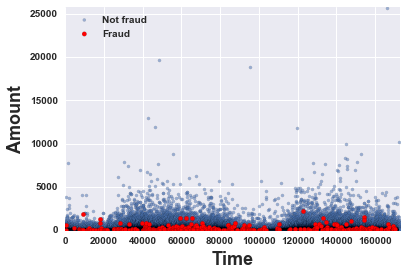

In [103]:
OneData = data[data.Class == 1]
ZeroData = data[data.Class == 0]
plt.scatter(ZeroData['Time'], ZeroData['Amount'], s=10, c=sns.color_palette()[0], alpha=0.5, marker="o", label='Not fraud', lw=0.1)
plt.scatter(OneData['Time'], OneData['Amount'], s=20, c='r', marker="o", label='Fraud', lw=0.1)
plt.ylim(ymin=0, ymax=np.amax(data['Amount'])+200)
plt.xlim(xmin=0, xmax=np.amax(data['Time'])+200)
plt.legend(loc='upper left')
plt.xlabel("Time", **hfont)
plt.ylabel("Amount", **hfont)
plt.savefig('Fraud Class Scatterplot.png', dpi = 300, bbox_inches='tight')

### Clearly the data is totally unbalanced!! 

#### This is a clear example where using a typical accuracy score to evaluate our classification algorithm. For example, if we just used a majority class to assign values to all records, we will still be having a high accuracy, BUT WE WOULD BE CLASSIFYING ALL "1" INCORRECTLY!!

#### There are several ways to approach this classification problem taking into consideration this unbalance. 

- Collect more data? Nice strategy but not applicable in this case
- Changing the performance metric:
    - Use the confusio nmatrix to calculate Precision, Recall
    - F1score (weighted average of precision recall)
    - Use Kappa - which is a classification accuracy normalized by the imbalance of the classes in the data
    - ROC curves - calculates sensitivity/specificity ratio.
- Resampling the dataset
    - Essentially this is a method that will process the data to have an approximate 50-50 ratio.
    - One way to achieve this is by OVER-sampling, which is adding copies of the under-represented class (better when you have little data)
    - Another is UNDER-sampling, which deletes instances from the over-represented class (better when he have lot's of data)

# Approach

1. We are not going to perform feature engineering in first instance. The dataset has been downgraded in order to contain 30 features (28 anonamised + time + amount). 
2. We will then compare what happens when using resampling and when not using it. We will test this approach using a simple logistic regression classifier.
3. We will evaluate the models by using some of the performance metrics mentioned above.
4. We will repeat the best resampling/not resampling method, by tuning the parameters in the logistic regression classifier.
5. We will finally perform classifications model using other classification algorithms.

# Setting our input and target variables + resampling.

#### 1. Normalising the amount column. The amount column is not in line with the anonimised features.

In [104]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


#### 2. Assigning X and Y. No resampling.

#### 3. Resampling.

- As we mentioned earlier, there are several ways to resample skewed data. Apart from under and over sampling, there is a very popular approach called SMOTE (Synthetic Minority Over-Sampling Technique), which is a combination of oversampling and undersampling, but the oversampling approach is not by replicating minority class but constructing new minority class data instance via an algorithm.

- In this notebook, we will use traditional UNDER-sampling. I will probably try to implement SMOTE in future versions of the code, but for now I will use traditional undersamplig.

- The way we will under sample the dataset will be by creating a 50/50 ratio. This will be done by randomly selecting "x" amount of sample from the majority class, being "x" the total number of records with the minority class.

In [105]:
X = data.ix[:, data.columns != 'Class']
y = data.ix[:, data.columns == 'Class']

In [106]:
# Number of data points in the minority class
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

# Picking the indices of the normal classes
normal_indices = data[data.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = data.iloc[under_sample_indices,:]

X_undersample = under_sample_data.ix[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.ix[:, under_sample_data.columns == 'Class']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


# Splitting data into train and test set. Cross validation will be used when calculating accuracies.

In [107]:
from sklearn.cross_validation import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample)+len(X_test_undersample))


Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


# Logistic regression classifier - Undersampled data

#### We are very interested in the recall score, because that is the metric that will help us try to capture the most fraudulent transactions. If you think how Accuracy, Precision and Recall work for a confusion matrix, recall would be the most interesting:

- Accuracy = (TP+TN)/total
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN)

#### As we know, due to the imbalacing of the data, many observations could be predicted as False Negatives, being, that we predict a normal transaction, but it is in fact a fraudulent one. Recall captures this.
- Obviously, trying to increase recall, tends to come with a decrease of precision. However, in our case, if we predict that a transaction is fraudulent and turns out not to be, is not a massive problem compared to the opposite. 
- We could even apply a cost function when having FN and FP with different weights for each type of error, but let's leave that aside for now.

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

#### Very ad-hoc function to print K_fold_scores

In [109]:
def printing_Kfold_scores(x_train_data,y_train_data):
    fold = KFold(len(y_train_data),5,shuffle=False) 

    # Different C parameters
    c_param_range = [0.01,0.1,1,10,100]

    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        for iteration, indices in enumerate(fold,start=1):

            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C = c_param, penalty = 'l1')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': recall score = ', recall_acc)

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.ix[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')

    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [110]:
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  1 : recall score =  0.945205479452
Iteration  2 : recall score =  0.931506849315
Iteration  3 : recall score =  1.0
Iteration  4 : recall score =  0.972972972973
Iteration  5 : recall score =  0.969696969697

Mean recall score  0.963876454287

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  1 : recall score =  0.849315068493
Iteration  2 : recall score =  0.86301369863
Iteration  3 : recall score =  0.949152542373
Iteration  4 : recall score =  0.932432432432
Iteration  5 : recall score =  0.909090909091

Mean recall score  0.900600930204

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration  1 : recall score =  0.86301369863
Iteration  2 : recall score =  0.86301369863
Iteration  3 : recall score =  0.983050847458
Iteration  4 : recall sc

#### Create a function to plot a fancy confusion matrix

In [111]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Predictions on test set and plotting confusion matrix

#### We have been talking about using the recall metric as our proxy of how effective our predictive model is. Even though recall is still the recall we want to calculate, just bear mind in mind that the undersampled data hasn't got a skewness towards a certain class, which doesn't make recall metric as critical. 

Recall metric in the testing dataset:  0.931972789116


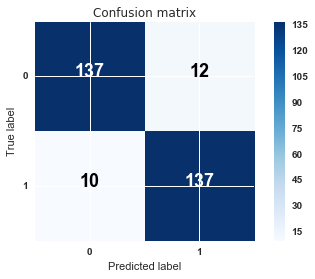

In [112]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

#### So, the model is offering an 93.2% recall accuracy on the generalised unseen data (test set). Not a bad percentage to be the first try. However, recall this is a 93.2% recall accuracy measure on the undersampled test set.

### Being happy with this result, let's apply the model we fitted and test it on the whole data.

Recall metric in the testing dataset:  0.918367346939


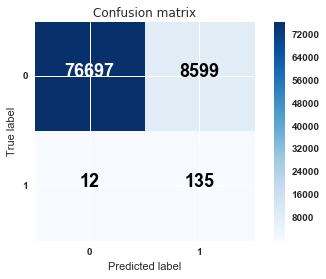

In [113]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

### Still a very decent recall accuracy when applying it to a much larger and skewed dataset! 

#### We can start to be happy with how initial approach is working.

### Plotting ROC curve and Precision-Recall curve.

- I find precision-recall curve much more convenient in this case as our problems relies on the "positive" class being more interesting than the negative class, but as we have calculated the recall precision, I am not going to plot the precision recall curves yet.

- AUC and ROC curve are also interesting to check if the model is also predicting as a whole correctly and not making many errors

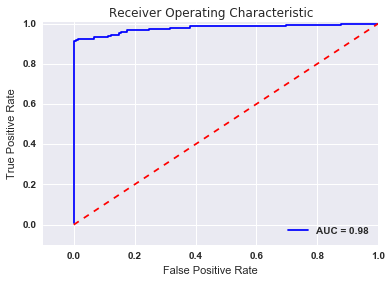

In [114]:
# ROC CURVE
lr = LogisticRegression(C = best_c, penalty = 'l1')
y_pred_undersample_score = lr.fit(X_train_undersample,y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### An additional comment that would be interesting to do is to initialise multiple undersampled datasets and repeat the process in loop. Remember that, to create an undersample data, we randomly got records from the majority class. Even though this is a valid technique, is doesn't represent the real population, so it would be interesting to repeat the process with different undersample configurations and check if the previous chosen parameters are still the most effective. In the end, the idea is to use a wider random representation of the whole dataset and rely on the averaged best parameters.

# Logistic regression classifier - Skewed data

#### Having tested our previous approach, I find really interesting to test the same process on the skewed data. Our intuition is that skewness will introduce issues difficult to capture, and therefore, provide a less effective algorithm.
- To be fair, taking into account the fact that the train and test datasets are substantially bigger than the undersampled ones, I believe a K-fold cross validation is necessary. I guess that by splitting the data with 60% in training set, 20% cross validation and 20% test should be enough... but let's take the same approach as before (no harm on this, it's just that K-fold is computationally more expensive)

In [115]:
best_c = printing_Kfold_scores(X_train,y_train)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  1 : recall score =  0.492537313433
Iteration  2 : recall score =  0.602739726027
Iteration  3 : recall score =  0.683333333333
Iteration  4 : recall score =  0.569230769231
Iteration  5 : recall score =  0.45

Mean recall score  0.559568228405

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  1 : recall score =  0.567164179104
Iteration  2 : recall score =  0.616438356164
Iteration  3 : recall score =  0.683333333333
Iteration  4 : recall score =  0.584615384615
Iteration  5 : recall score =  0.525

Mean recall score  0.595310250644

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration  1 : recall score =  0.55223880597
Iteration  2 : recall score =  0.616438356164
Iteration  3 : recall score =  0.716666666667
Iteration  4 : recall score = 

Recall metric in the testing dataset:  0.619047619048


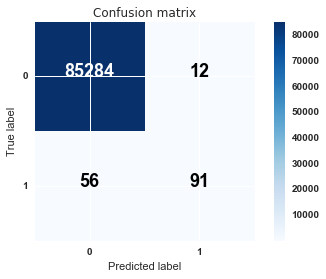

In [116]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train,y_train.values.ravel())
y_pred_undersample = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

# Before continuing... changing classification threshold.

#### We have seen that by undersampling the data, our algorithm does a much better job at detecting fraud. I wanted also to show how can we tweak our final classification by changing the thresold.
- Initially, you build the classification model and then you predict unseen data using it.
- We previously used the "predict()" method to decided whether a record should belong to "1" or "0". 
- There is another method "predict_proba()".
    - This method returns the probabilities for each class. The idea is that by changing the threshold to assign a record to class 1, we can control precision and recall.
    
#### Let's check this using the undersampled data (best C_param = 0.01)

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.986394557823
Recall metric in the testing dataset:  0.931972789116
Recall metric in the testing dataset:  0.884353741497
Recall metric in the testing dataset:  0.836734693878
Recall metric in the testing dataset:  0.755102040816
Recall metric in the testing dataset:  0.585034013605


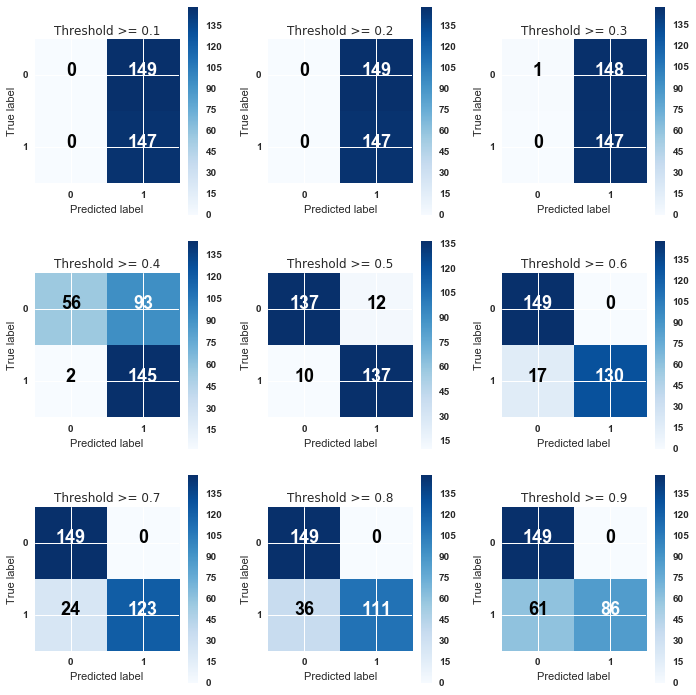

In [117]:
lr = LogisticRegression(C = 0.01, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_undersample_proba[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test_undersample,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i) 

### The pattern is very clear: the more you lower the required probability to put a certain in the class "1" category, more records will be put in that bucket.
#### This implies an increase in recall (we want all the "1"s), but at the same time, a decrease in precision (we misclassify many of the other class).
### Therefore, even though recall is our goal metric (do not miss a fraud transaction), we also want to keep the model being accurate as a whole.
- There is an option I think could be quite interesting to tackle this. We could assing cost to misclassifications, but being interested in classifying "1s" correctly, the cost for misclassifying "1s" should be bigger than "0" misclassifications. After that, the algorithm would select the threshold which minimises the total cost. A drawback I see is that we have to manually select the weight of each cost... therefore, I will leave this know as a thought.
- Going back to the threshold changing, there is an option which is the Precisio-Recall curve. By visually seeing the performance of the model depending on the threshold we choose, we can investigate a sweet spot where recall is high enough whilst keeping a high precision value.

### Investigate Precision-Recall curve and area under this curve.

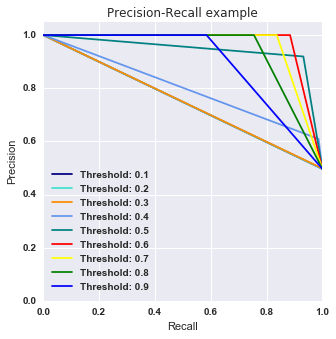

In [118]:
from itertools import cycle

lr = LogisticRegression(C = 0.01, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(5,5))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_undersample_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test_undersample,y_test_predictions_prob)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc="lower left")

# Upcoming updates: 
## testing SVMs
## testing decision trees